<a href="https://colab.research.google.com/github/elliot-linsey/QMUL/blob/main/ECS7020P_Lab05v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Exploring classification

A classifier is a model that predicts a **discrete label** when shown a set of **predictors**. In machine learning, we build classifiers using datasets extracted from our target population. 

Classifiers can be defined as partitions of the **predictor space** into **decision regions**. A decision region is a region within the predictor space such that any sample that lies within it is assigned the same label. Decision regions are separated by **decision boundaries** and therefore, it is common to define classifiers using their decision boundaries, for instance:
- If sample $x_i$ lies on one side of the boundary, it is classified as <font color=red> **O** </font>.
- If $x_i$ lies on the other side, it is classified as <font color=blue> **O** </font>.

Even though decision boundaries and regions define classifiers, not every classifier uses explicitely these notions to label samples. The kNN algorithm is one example of this: to classify a sample kNN doesn't look for the boundary, but the sample's k nearest neighbours.

In this lab we will explore the basics of classification. We will first consider **linear classifiers**, which produce decision regions separated by linear boundaries. We will then use the **logistic function** to create a notion of classifier "certainty", which then we will use to define the **logistic regression classifier**.  We will finally implement two **optimisation approaches** to identify the logistic regression solution, namely **exhaustive search** and **gradient descent**. 






# Linear classifiers

Linear classifiers partition the predictor space into decision regions separated by linear boundaries (e.g. straight lines). Let's illustrate linear classifiers using **a binary classifier** (two classes) in a **2D predictor space**.

Let $x_1$ and $x_2$ be the predictors. A linear boundary in the predictor space is defined by the equation:

$w_0 + w_1 x_1 + w_2 x_2 =0$,

where $w_0$, $w_1$ and $w_2$ are the coefficients of the classifier. 

Using **vector notation** (this is much more convenient), we create the **extended predictor vector** $\boldsymbol{x} = [1, x_1, x_2]^T$ and the **coefficients vector** $\boldsymbol{w} = [w_0, w_1, w_2]^T$, and use them to express the linear boundary by the equivalent equation

$\boldsymbol{x}^T \boldsymbol{w} = 0$.

If you do not understand why the two previous equations are equivalent, please **revise the material on basic mathematical notation and matrix algebra now**. 


Consider the classifier defined by the coefficients vector $\boldsymbol{w} = [-0.25, -1, 1]^T$. Can you plot it on a piece of paper? Try to do it before continuing to check your understanding. 

Notice that by making $\boldsymbol{x}^T \boldsymbol{w} = 0$, we get

\begin{eqnarray}
\boldsymbol{x}^T \boldsymbol{w} &=& [1, x_1, x_2] [-0.25, -1, 1]^T \\
&=& -0.25\times 1 + (-1)\times x_1 + 1\times x_2 \\
&=& -0.25 - x_1 + x_2 \\
&=& 0, \\ \\
\rightarrow x_2 &=& x_1 + 0.25.
\end{eqnarray} 

Hence the boundary $\boldsymbol{w} = [-0.25, -1, 1]^T$ is a straight line with a 45-degree slope and 0.25 intercept. 

Let's use the values 0 and 1 as labels for the two classes. Using numerical values for labels is very convenient from an implementation perspective. Our classifier will work as follows:

- If $\boldsymbol{x}_i^T \boldsymbol{w} > 0$, then $\hat{y}_i = 1$.
- If $\boldsymbol{x}_i^T \boldsymbol{w} < 0$, then $\hat{y}_i = 0$.

Let's classify the following two samples:

- First sample: $x_1 = 1$, $x_2 = 2$. 
- Second sample: $x_1 = 2$, $x_2 = 1$.

You can do this easily by hand (try it!), but let's use the cell bellow:

In [4]:
xs = [1,1,2]
ws = [-0.25,-1,1]

xtw = (-0.25*1) + (-1*1) + (1*2)
xtw = -0.25 + -1 + 2
xtw

0.75

In [5]:
xs = [1,2,1]
ws = [-0.25,-1,1]

xtw = (-0.25*1) + (-1*2) + (1*1)
xtw = -0.25 + -2 + 1
xtw

-1.25

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

# This is our coefficients vector
w = np.array([-0.25, -1, 1], ndmin=2).T

# These are the two samples that we are considering
firstsample = np.array([1, 1, 2], ndmin=2).T
secondsample = np.array([1, 2, 1], ndmin=2).T

# These are the predictions
firstlabel = 1*(np.dot(firstsample.T,w).item() > 0)
secondlabel = 1*(np.dot(secondsample.T,w).item() > 0)

print('The predicted label of firstsample, where x1=', firstsample[1], 'and x2=', firstsample[2] ,', is ', firstlabel)
print('The predicted label of secondsample, where x1=', secondsample[1], 'and x2=', secondsample[2] ,', is ', secondlabel)

The predicted label of firstsample, where x1= [1] and x2= [2] , is  1
The predicted label of secondsample, where x1= [2] and x2= [1] , is  0


We have used the trick of multiplying by 1 (`1*`) to convert the boolean values True and False to the numerical values 1 and 0, and `item()` to extract a scalar value from a (1,1) NumPy array. Go ahead and run the cell again without `item()` first and then without `1*` ans see what you obtain. It will be the **same result**, but **different representation**.

To predict the label of a large number of samples, instead of operating on each sample separately, we can create a **design matrix** $\boldsymbol{X}$ and multiply it by $\boldsymbol{w}$. Note that in a design matrix, each row is the extended vector of one of the samples. A vector of predicted labels $\boldsymbol{\hat{y}}$ can then be obtained by comparing the result of the product $\boldsymbol{X} \boldsymbol{w}$ with 0.

Let's do this for a collection of 25 samples on a rectangular grid in the range $-1 \leq x_1 \leq 1$ and $-1 \leq x_2 \leq 1$. We first build the grid using `meshgrid()` as follows:  

My 25 grid samples are (x1, x2): 
 [[-1.  -1. ]
 [-0.5 -1. ]
 [ 0.  -1. ]
 [ 0.5 -1. ]
 [ 1.  -1. ]
 [-1.  -0.5]
 [-0.5 -0.5]
 [ 0.  -0.5]
 [ 0.5 -0.5]
 [ 1.  -0.5]
 [-1.   0. ]
 [-0.5  0. ]
 [ 0.   0. ]
 [ 0.5  0. ]
 [ 1.   0. ]
 [-1.   0.5]
 [-0.5  0.5]
 [ 0.   0.5]
 [ 0.5  0.5]
 [ 1.   0.5]
 [-1.   1. ]
 [-0.5  1. ]
 [ 0.   1. ]
 [ 0.5  1. ]
 [ 1.   1. ]]
My design matrix is 
 [[ 1.  -1.  -1. ]
 [ 1.  -0.5 -1. ]
 [ 1.   0.  -1. ]
 [ 1.   0.5 -1. ]
 [ 1.   1.  -1. ]
 [ 1.  -1.  -0.5]
 [ 1.  -0.5 -0.5]
 [ 1.   0.  -0.5]
 [ 1.   0.5 -0.5]
 [ 1.   1.  -0.5]
 [ 1.  -1.   0. ]
 [ 1.  -0.5  0. ]
 [ 1.   0.   0. ]
 [ 1.   0.5  0. ]
 [ 1.   1.   0. ]
 [ 1.  -1.   0.5]
 [ 1.  -0.5  0.5]
 [ 1.   0.   0.5]
 [ 1.   0.5  0.5]
 [ 1.   1.   0.5]
 [ 1.  -1.   1. ]
 [ 1.  -0.5  1. ]
 [ 1.   0.   1. ]
 [ 1.   0.5  1. ]
 [ 1.   1.   1. ]]


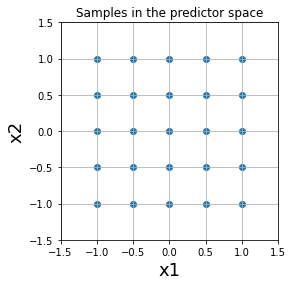

In [12]:
# Here we create a dataset consiting of 25 samples on a rectangular grid
coor1 = np.linspace(-1, 1, 5)
coor2 = np.linspace(-1, 1, 5)

x1_mesh, x2_mesh = np.meshgrid(coor1, coor2)
#print(x1_mesh)
x1 = x1_mesh.ravel()
x2 = x2_mesh.ravel()

print("My 25 grid samples are (x1, x2): \n", np.column_stack([x1, x2]))


# The design matrix is created here
X = np.column_stack([np.ones(x1.shape), x1, x2])

print("My design matrix is \n", X)



# Finally, we plot the 25 samples on the predictor space
plt.scatter(x1, x2)
plt.title("Samples in the predictor space")
plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

Let's obtain and plot the labels predicted by the classifier $\boldsymbol{w} = [-0.25, -1, 1]^T$:

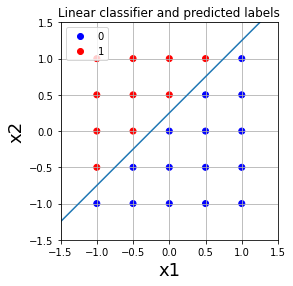

In [16]:
# This line of code produces the predicted labels for all the samples in our dataset
yPred = 1*(np.dot(X, w) > 0)
#print(yPred)

# Plots each sample with a colour-coded (predicted) label
scatter = plt.scatter(x1, x2, c=yPred, cmap=plt.get_cmap('bwr'))
plt.title("Linear classifier and predicted labels")
plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend(handles=scatter.legend_elements()[0], labels=["0", "1"])

# Plots the decision boundary
x1_L = np.linspace(-1.5, 1.5, 5)
x2_L = x1_L + 0.25
plt.plot(x1_L, x2_L)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)

plt.show()

We can represent the decision regions by evaluating a dense grid of points (100 $\times$ 100 in the cell below) and plotting their predicted labels as an image using `imshow()`:

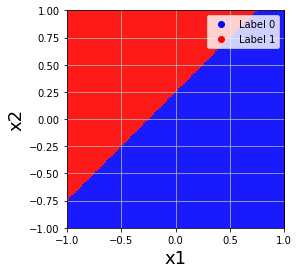

In [20]:
# Creates 100x100 samples on a rectangular grid, creates a design matrix and computes the predicted label
coor1 = np.linspace(-1, 1, 100)
coor2 = np.linspace(-1, 1, 100)
x1_100, x2_100 = np.meshgrid(coor1, coor2)
X = np.column_stack([np.ones(x1_100.ravel().shape), x1_100.ravel(), x2_100.ravel()])
yPred = 1*(np.dot(X, w) > 0)

# Plots the predicted labels for each sample as an image, allowing us to visualise the decision regions
plt.imshow(yPred.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-1, 1, -1, 1), 
                          origin = 'lower', 
                          alpha = 0.9)

plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(handles=scatter.legend_elements()[0], labels=["Label 0", "Label 1"])
plt.show()

# Logistic function: The certainty of a linear classifier

Now that we know how to define, visualise and use a linear classifier, let's create the notion of classifier's certainty using the **logistic function** (also known as expit or sigmoid) $p(d)$:

$$
p(d) =\frac{e^d}{e^d + 1} = \frac{1}{1 + e^{-d}}
$$

Let's plot it first (we could easily implement it ourselves, but we will just use the `expit` function from the `scipy` scientific library):

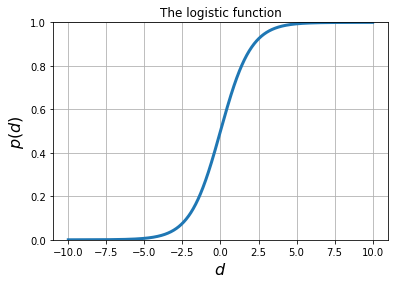

In [21]:
from scipy.special import expit

d = np.linspace(-10, 10, 1000)

plt.title("The logistic function")
plt.plot(d, expit(d), linewidth = 3)
plt.xlabel('$d$', fontsize=16)
plt.ylabel('$p(d)$', fontsize=16)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Notice that: 
- $p(d) \rightarrow 1$ as $d \rightarrow \infty$, 
- $p(0) = 0.5$, 
- $p(d) \rightarrow 0$ as $d \rightarrow -\infty$.

In classification, the quantity $\boldsymbol{x}^T\boldsymbol{w}$ can be interpreted as a distance between the sample $\boldsymbol{x}$ and the boundary. Setting $d=\boldsymbol{x}^T\boldsymbol{w}$, we will use the quantity $p(\boldsymbol{x}^T\boldsymbol{w})$ to measure a classifier's certainty that a sample $\boldsymbol{x}$ belongs to one of the classes.

We will define a new function `p(X, w)` corresponding to the quantity $p(\boldsymbol{x}^T\boldsymbol{w})$: 

In [22]:
def p(X, w):
  return expit(np.dot(X, w))

Let's see how we can use the logistic function to define the notion of certainty in classifiers. We will first create a new linear classifier defined by the coefficients $\boldsymbol{w} = [0.25, -1, 0]^T$ and show the decision regions that it defines:

In [ ]:
ws = [0.25, -1, 0]
xs = [1, x1, x2]

xtw = (1*0.25) + (-1x1) + (0x2)
xtw = 0.25 + -1x1
1x1 = 0.25



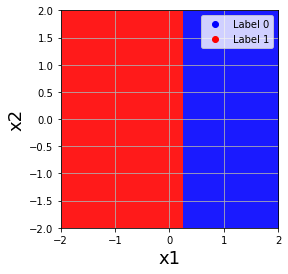

In [25]:
# Coefficients of the new classifier
w = np.array([0.25, -1, 0], ndmin=2).T

# 100x100 samples used to visualise the decision regions, design matrix and predicted labels for each sample
coor1 = np.linspace(-2, 2, 100)
coor2 = np.linspace(-2, 2, 100)
x1, x2 = np.meshgrid(coor1, coor2)
X = np.column_stack([np.ones(x1.ravel().shape), x1.ravel(), x2.ravel()])
yPred = 1*(np.dot(X, w) > 0)

# Shows decision regiones by showing as an image the predicted label of the 100x100 samples
image = plt.imshow(yPred.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-2, 2, -2, 2), 
                          origin = 'lower', 
                          alpha = 0.9)

plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(handles=scatter.legend_elements()[0], labels=["Label 0", "Label 1"])
plt.show()


Would you have obtained the same decision regions by hand? Make sure that you are capable of identifying linear boundaries in a 2D predictor space using the coefficients vector $\boldsymbol{w}$.

Let's now consider 7 samples that **belong to class 1**. The quantity $p(\boldsymbol{x}^T\boldsymbol{w})$ corresponds to the classifier's certainty that each sample belongs to class 1. We can now plot the 7 sample along with the classifier's certainty for each one of them: 


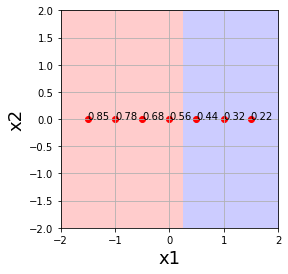

In [26]:
# 7 samples
x1 = np.array([1.5, 1, 0.5,  0, -0.5, -1, -1.5])
x2 = np.array(np.zeros(x1.shape))

# Classifier's certainty that each sample belongs to class 1
X = np.column_stack([np.ones(x1.shape), x1, x2])
certainty_1 = p(X, w)


# Visualisation of the classifier, sample, and certainty values
image = plt.imshow(yPred.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-2, 2, -2, 2), 
                          origin = 'lower', 
                          alpha = 0.2)

plt.scatter(x1, x2, color = 'red')
plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)


for i, c1 in enumerate(certainty_1):
    plt.annotate(round(c1.item(),2), (x1[i], x2[i]))

plt.show()


If the same samples **belong to class 0 instead**, the classifier's certainty that they belong to class 0 is computed as $1 - p(\boldsymbol{x}^T\boldsymbol{w})$:

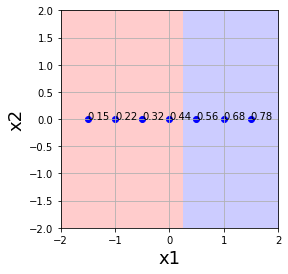

In [27]:
# Classifier's certainty that each sample belongs to 0
certainty_0 = 1-p(X, w)

# Visualisation of the classifier, samples and their certainties
image = plt.imshow(yPred.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-2, 2, -2, 2), 
                          origin = 'lower', 
                          alpha = 0.2)

plt.scatter(x1, x2, color = 'blue')
plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)

for i, c1 in enumerate(certainty_0):
    plt.annotate(round(c1.item(),2), (x1[i], x2[i]))

plt.show()

As you can see, the certainty value for a sample that lies on the correct decision region is greater than 0.5, and increases towards 1 as we move away from the boundary. Samples that lie on the wrong decision region are assigned a certainty below 0.5, which decreases towards 0 as we move away from the boundary.

In addition to computing the classifer's certainty for each individual sample, we can also do it for an entire dataset by simply multiplying the individual certainties. The resulting quantity $L$ is known as the **likelihood**:

$$
L=\prod_{y_i=0}\left(1-p(\boldsymbol{x}_i^T \boldsymbol{w})\right) \prod_{y_i=1}p(\boldsymbol{x}_i^T \boldsymbol{w})
$$

The **negative log-likelihood** is a more convenient way to quantify the classifier's certainty: 

$$
-\log L(\boldsymbol{w})=-\sum_{y_i=0}\log\left(1-p(\boldsymbol{x}_i^T \boldsymbol{w})\right) -\sum_{y_i=1}\log p(\boldsymbol{x}_i^T \boldsymbol{w})\\
= -\sum_{y_i}[(1-y_i)\log\left(1-p(\boldsymbol{x}_i^T \boldsymbol{w})\right) +y_i\log p(\boldsymbol{x}_i^T \boldsymbol{w})]
$$



In the following cell, we will define several new functions that implement the code for predicting labels and calculating the likelihood, negative log-likelihoods and accuracy of a classifier:

In [28]:
# Returns the predicted labels
def prediction(X, w):
  return 1*(np.dot(X, w) > 0)

# Computes the likelihood
def likelihood(X, w, y):
  return np.prod(y*p(X, w) + (1-y)*(1-p(X, w)))

# Computes the negative log-likelihood
def negLogLikelihood(X, w, y):
  return -np.sum(y * np.log(p(X,w)) + (1 - y) * np.log(1 - p(X,w)))

# Computes the accuracy by comparing true labels y and predicted labels yP
def accuracy(y, yP):
  return np.sum(y==yP)/len(y)

Let's present two different datasets to our classifier and calculate the likelihood $L$, negative log-likelihood $l$, accuracy and error rate for each dataset. The following cell considers the first dataset:

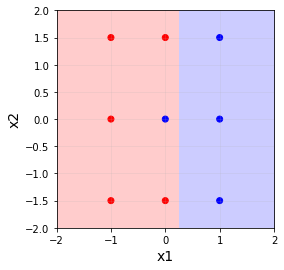

The individual certainties for each sample are 
 [[0.777]
 [0.562]
 [0.679]
 [0.777]
 [0.438]
 [0.679]
 [0.777]
 [0.562]
 [0.679]]
The likelihood is L= 0.020359278561933054
The negative log-likelihood is -log(L)= 3.8942185220173493
The accuracy is  0.89
The error rate is  0.11


In [29]:

# 1st dataset consisting of 9 samples, x1 and x2 are the predictors, y is the TRUE label
x1 = np.array([-1, 0, 1, -1,  0, 1, -1, 0, 1], ndmin=2).T
x2 = np.array([1.5, 1.5, 1.5,  0, 0, 0, -1.5, -1.5, -1.5], ndmin=2).T
y  = np.array([1, 1, 0, 1,  0, 0, 1, 1, 0], ndmin=2).T

# Visualisation of the decision regions and samples. The colour of the samples corresponds to the TRUE LABEL
image = plt.imshow(yPred.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-2, 2, -2, 2), 
                          origin = 'lower', 
                          alpha = 0.2)

scatter = plt.scatter(x1, x2, c=y, cmap=plt.get_cmap('bwr'))

plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(alpha=0.2)
plt.show()

# Desing matrix, predicted label, certainties, likelihoods and negative log-likelihoods
X = np.column_stack([np.ones(x1.shape), x1, x2])
yP = prediction(X, w)
certainty = y*p(X, w) + (1-y)*(1-p(X, w))
L = likelihood(X, w, y)
l = negLogLikelihood(X, w, y)

print("The individual certainties for each sample are \n", certainty)
print("The likelihood is L=", L)
print("The negative log-likelihood is -log(L)=",l)

# Accuracy and error rate
A = accuracy(y, yP)
E = 1 - A
print("The accuracy is ", round(A, 2))
print("The error rate is ", round(E,2))


The cell bellow considers the second dataset:

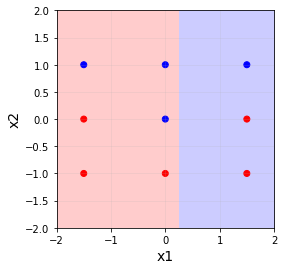

The individual certainties for each sample are 
 [[0.223]
 [0.223]
 [0.777]
 [0.562]
 [0.438]
 [0.438]
 [0.852]
 [0.852]
 [0.148]]
The likelihood is L= 0.00044640767453471054
The negative log-likelihood is -log(L)= 7.714277954986911
The accuracy is  0.44
The error rate is  0.56


In [30]:
# 2nd dataset consisting of 9 samples

x1 = np.array([1.5, 1.5, 1.5,  0, 0, 0, -1.5, -1.5, -1.5], ndmin=2).T
x2 = np.array([-1, 0, 1, -1,  0, 1, -1, 0, 1], ndmin=2).T
y  = np.array([1, 1, 0, 1,  0, 0, 1, 1, 0], ndmin=2).T

# Visualisation of the decision regions and samples. The colour corresponds to the TRUE LABEL
image = plt.imshow(yPred.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-2, 2, -2, 2), 
                          origin = 'lower', 
                          alpha = 0.2)

scatter = plt.scatter(x1, x2, c=y, cmap=plt.get_cmap('bwr'))

plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(alpha=0.2)

plt.show()

# Desing matrix, predicted label, certainties, likelihoods and negative log-likelihoods
X = np.column_stack([np.ones(x1.shape), x1, x2])
yP = prediction(X, w)
certainty = y*p(X, w) + (1-y)*(1-p(X, w))
L = likelihood(X, w, y)
l = negLogLikelihood(X, w, y)

print("The individual certainties for each sample are \n", certainty)
print("The likelihood is L=", L)
print("The negative log-likelihood is -log(L)=", l)

# Accuracy and error rate
A = accuracy(y, yP)
E = 1 - A
print("The accuracy is ", round(A, 2))
print("The error rate is ", round(E,2))

Compare the likelihood, negative log-likelihood, accuracies and error rate values for both datasets. The classifier does a better job with the first dataset. Visually, it is clear that it separates the first dataset better. In addition, the classifier produces a higher likelihood (lower negative log-likelihood) and higher accuracy (lower error rate) when shown the first dataset.

# Comparing classifiers

In the previous section, we have shown two different datasets to the same classifier. We will now consider a single dataset and different linear classifiers. 

Upload the files `lab5_train.csv` and `lab5_test.csv`. Let's start by plotting the training dataset:

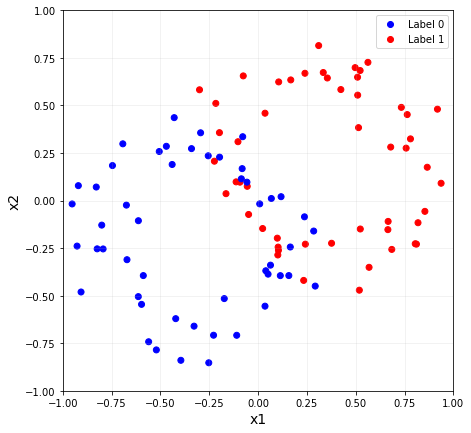

In [31]:
import pandas as pd

# Loads training and test datasets
df_train = pd.read_csv("lab5_train.csv")
df_test = pd.read_csv("lab5_test.csv")

N = df_train['Label'].size

# Stores each attribute in different (N,1) NumPy arrays
x1_train = df_train['Attribute_1'].to_numpy().reshape(N,1)
x2_train = df_train['Attribute_2'].to_numpy().reshape(N,1)
y_train = df_train['Label'].to_numpy().reshape(N,1)



# Plots the dataset
fig = plt.figure(figsize=(7, 7))

scatter = plt.scatter(x1_train, x2_train, c=y_train, cmap=plt.get_cmap('bwr'))
plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(alpha=0.2)
plt.legend(handles=scatter.legend_elements()[0], labels=["Label 0", "Label 1"])
plt.show()


Let's now consider two linear classifiers A and B defined by the coefficient vectors $\boldsymbol{w}_A=[0, 1, 1]$ and $\boldsymbol{w}_B=[0, 1, -1]$, respectively. Let's show their decision regions first:

In [ ]:
ws = [0,1,1]
xs = [1,x1,x2]

xtw = (0*1) + (1*x1) + (1*x2)
xtw = 0 + x1 + x2
x2 = -x1

ws = [0,1,-1]
xs = [1,x1,x2]

xtw = (0*1) + (1*x1) + (-1*x2)
xtw = 0 + x1 + -x2
x2 = x1

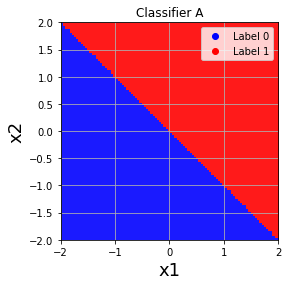

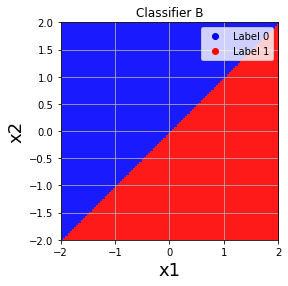

In [32]:
# Coefficients of the classifier
wA = np.array([0, 1, 1], ndmin=2).T
wB = np.array([0, 1, -1], ndmin=2).T

# 100x100 samples used to visualise the decision regions, design matrix and predicted labels for each sample
coor1 = np.linspace(-2, 2, 100)
coor2 = np.linspace(-2, 2, 100)
x1, x2 = np.meshgrid(coor1, coor2)
X = np.column_stack([np.ones(x1.ravel().shape), x1.ravel(), x2.ravel()])
yPredA = prediction(X, wA)
yPredB = prediction(X, wB)

# Shows decision regiones by showing as an image the predicted label of the 100x100 samples
image = plt.imshow(yPredA.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-2, 2, -2, 2), 
                          origin = 'lower', 
                          alpha = 0.9)

plt.title("Classifier A")
plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(handles=scatter.legend_elements()[0], labels=["Label 0", "Label 1"])

plt.figure()

image = plt.imshow(yPredB.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-2, 2, -2, 2), 
                          origin = 'lower', 
                          alpha = 0.9)

plt.title("Classifier B")
plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(handles=scatter.legend_elements()[0], labels=["Label 0", "Label 1"])

plt.show()

Visually, which classifier do you think will do a better job? Let's obtain their training accuracies, error rate, likelihood and negative log-likelihood.

    CLASSIFIER A
The likelihood is L= 4.0314938136757435e-22
The negative log-likelihood is -log(L)= 49.26273506522414
The accuracy is  0.7920792079207921
The error rate is  0.20792079207920788

    CLASSIFIER B
The likelihood is L= 1.9147232237372428e-29
The negative log-likelihood is -log(L)= 66.12539461532579
The accuracy is  0.5544554455445545
The error rate is  0.45


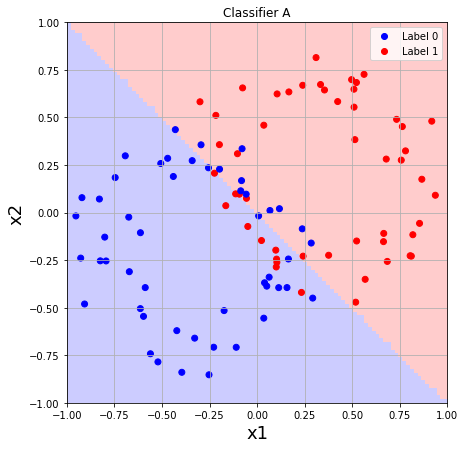

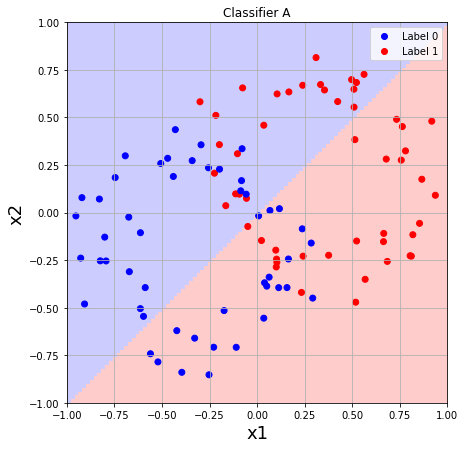

In [33]:
# Desing matrix, predicted label
X_train = np.column_stack([np.ones(x1_train.shape), x1_train, x2_train])
y_trainPredA = prediction(X_train, wA)
y_trainPredB = prediction(X_train, wB)

# Likelihood, neg log-likelihood, accuracy and error rate for classifier A
LA = likelihood(X_train, wA, y_train)
nlogLA = negLogLikelihood(X_train, wA, y_train)
AA = accuracy(y_train, y_trainPredA)
EA = 1 - AA

# Likelihood, neg log-likelihood, accuracy and error rate for classifier B
LB = likelihood(X_train, wB, y_train)
nlogLB = negLogLikelihood(X_train, wB, y_train)
AB = accuracy(y_train, y_trainPredB)
EB = 1 - AB

# Plots dataset and classifier A regions, prints likelihood, accuracy, etc
plt.figure(figsize=(7, 7))
image = plt.imshow(yPredA.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-1, 1, -1, 1), 
                          origin = 'lower', 
                          alpha = 0.2)
scatter = plt.scatter(x1_train, x2_train, c=y_train, cmap=plt.get_cmap('bwr'))
plt.title("Classifier A")
plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(handles=scatter.legend_elements()[0], labels=["Label 0", "Label 1"])


print("    CLASSIFIER A")
print("The likelihood is L=", LA)
print("The negative log-likelihood is -log(L)=",nlogLA)
print("The accuracy is ", AA)
print("The error rate is ", EA)


# Plots dataset and classifier B regions, prints likelihood, accuracy, etc
plt.figure(figsize=(7, 7))
image = plt.imshow(yPredB.reshape((100, 100)), 
                          cmap = 'bwr', 
                          interpolation='none', 
                          extent = (-1, 1, -1, 1), 
                          origin = 'lower', 
                          alpha = 0.2)
scatter = plt.scatter(x1_train, x2_train, c=y_train, cmap=plt.get_cmap('bwr'))
plt.title("Classifier A")
plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(handles=scatter.legend_elements()[0], labels=["Label 0", "Label 1"])


print("\n    CLASSIFIER B")
print("The likelihood is L=", LB)
print("The negative log-likelihood is -log(L)=",nlogLB)
print("The accuracy is ", AB)
print("The error rate is ", round(EB,2))

Based on these results, if we had to choose between the two, it is clear that we would select classifier A. It is also worth noting that the likelihood of both classifiers is a very small number. Remember that the likelihood is obtained by multiplying individual certainties, which are always less than one. Therefore, the larger the dataset, the closer the likelihood will be to zero. This can lead to **underflow**, which is a situation where your computer cannot represent a very small number and it is one of the reasons why we use the log-likelihood, as its values will not suffer from underflow.

The following cell represents the quantity $p(\boldsymbol{x}^T\boldsymbol{w})$ in every point of the predictor space for a linear boundary defined by the coefficients `wTryMe` Essentially, you will be looking at the logistic function in 2D. Go ahead and change the value of the coefficients to see what happens with those values. For instance: 
- Multiply all the coefficents by the same positive number, what do you observe? Does the accuracty change? And the likelihood? 
- What if you multiply all the coefficients by -1? 
- Change the coefficients individually to see what happens to the linear boundary.

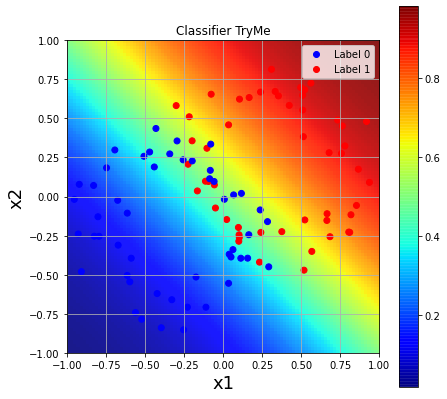

    CLASSIFIER TRYME
The likelihood is L= 4.0314938136757435e-22
The negative log-likelihood is -log(L)= 49.26273506522414
The accuracy is  0.7920792079207921
The error rate is  0.20792079207920788


In [45]:
# Change the coefficients below to see how the classifier changes
wTryMe = np.array([0,1,1], ndmin=2).T

# 100x100 samples used to visualise the decision regions, design matrix and predicted labels for each sample
coor1 = np.linspace(-2, 2, 100)
coor2 = np.linspace(-2, 2, 100)
x1, x2 = np.meshgrid(coor1, coor2)
X = np.column_stack([np.ones(x1.ravel().shape), x1.ravel(), x2.ravel()])

# Plots dataset and classifier TryMe regions, prints likelihood, accuracy, etc
plt.figure(figsize=(7, 7))
image = plt.imshow(p(X, wTryMe).reshape((100, 100)), 
                          cmap = 'jet', 
                          interpolation='none', 
                          extent = (-1, 1, -1, 1), 
                          origin = 'lower', 
                          alpha = 0.9)
plt.colorbar()

scatter = plt.scatter(x1_train, x2_train, c=y_train, cmap=plt.get_cmap('bwr'))
plt.title("Classifier TryMe")
plt.xlabel("x1", fontsize=18)
plt.ylabel("x2", fontsize=18)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(handles=scatter.legend_elements()[0], labels=["Label 0", "Label 1"])

plt.show()

y_trainTryMe = prediction(X_train, wTryMe)

# Likelihood, neg log-likelihood, accuracy and error rate for classifier A
LTryMe = likelihood(X_train, wTryMe, y_train)
nlogLTryMe = negLogLikelihood(X_train, wTryMe, y_train)
ATryMe = accuracy(y_train, y_trainTryMe)
ETryMe = 1 - ATryMe

print("    CLASSIFIER TRYME")
print("The likelihood is L=", LTryMe)
print("The negative log-likelihood is -log(L)=",nlogLTryMe)
print("The accuracy is ", ATryMe)
print("The error rate is ", ETryMe)

Likelihood ranges from 0 to 1. We want values closer to 1
Negative log-likelihood goes from 0 to infinity. We want values closer to 0.
They both demonstrate the same thing, but negative log-likelihood is easier to compute.

# Logistic regression: Optimisation

We have used the logistic function to create a notion of certainty for classifiers, namely the likelihood (or equivalently, the negative log-likelihood). We have seen that classifiers that separate well samples from different classes have a high likelihood, whereas classifiers that produce a poor separation have low likelihood values.

**Logistic "regression" classifiers** use the likelihood function $L$ as the objective function. Given a dataset, the best classifier is defined as the one with the **highest likelihood** value. This classifier also provides the **highest log-likelihood** value and obviously the **lowest negative log-likelihood** value.

A separate question is, how do we find the classifier with the highest likelihood? For this, we need to use an **optimisation** strategy. In this section we will implement two approaches to find the logistic regression solution, namely **exhaustive search** and **gradient descent**. We will use the error surface defined by **negative log-likelihood** to find the logistic regression solution. This surface is **convex**, so we don't need to worry about local minima. 



**Exhaustive approaches** basically evaluate a large number of options individually and select the model with the best performance. In the following cell we evaluate 8000 different coefficient vectors and select the one with the lowest negative log-likelihood as our solution.

In [46]:
from itertools import product

lw0 = np.linspace(-1, 1, 20)
lw1 = np.linspace(-1, 1, 20)
lw2 = np.linspace(-1, 1, 20)

all_possible_weights = product(lw0, lw1, lw2)
lowest_negLogLike = np.Infinity

for i, weights in enumerate(all_possible_weights):
  current_negLogLike = negLogLikelihood(X_train, np.array(weights, ndmin=2).T, y_train)
  if current_negLogLike < lowest_negLogLike:
    best_weights = np.array(weights, ndmin=2).T
    lowest_negLogLike = current_negLogLike
    best_y_train_pred = prediction(X_train, best_weights)
    print('\n \n New best w = {} | '.format(best_weights.ravel()), end='')
    print('-Log(L) = {:8.5f} | '.format(current_negLogLike), end='')
    print('Accuracy = {:.2f}'.format(accuracy(y_train, best_y_train_pred)), end='')
    

print('\n \n We have explored', i+1, 'different coefficient vectors and the best one is:', best_weights.ravel())



 
 New best w = [-1. -1. -1.] | -Log(L) = 115.48506 | Accuracy = 0.39
 
 New best w = [-1.    -1.    -0.895] | -Log(L) = 114.00315 | Accuracy = 0.40
 
 New best w = [-1.    -1.    -0.789] | -Log(L) = 112.55563 | Accuracy = 0.42
 
 New best w = [-1.    -1.    -0.684] | -Log(L) = 111.14290 | Accuracy = 0.46
 
 New best w = [-1.    -1.    -0.579] | -Log(L) = 109.76534 | Accuracy = 0.48
 
 New best w = [-1.    -1.    -0.474] | -Log(L) = 108.42329 | Accuracy = 0.48
 
 New best w = [-1.    -1.    -0.368] | -Log(L) = 107.11706 | Accuracy = 0.48
 
 New best w = [-1.    -1.    -0.263] | -Log(L) = 105.84692 | Accuracy = 0.49
 
 New best w = [-1.    -1.    -0.158] | -Log(L) = 104.61311 | Accuracy = 0.50
 
 New best w = [-1.    -1.    -0.053] | -Log(L) = 103.41582 | Accuracy = 0.50
 
 New best w = [-1.    -1.     0.053] | -Log(L) = 102.25524 | Accuracy = 0.50
 
 New best w = [-1.    -1.     0.158] | -Log(L) = 101.13150 | Accuracy = 0.50
 
 New best w = [-1.    -1.     0.263] | -Log(L) = 100.04472

Exhaustive approaches are computationally inefficient. **Gradient descent** appoaches follow the slope of the error surface to reach the optimal solution and require evaluating fewer models. We will try gradient descent next.

Instead of implementing the gradient descent algorithms ourselves, we are going to use the `minimize` function from the `optimization` module implemented as part of the `scipy` library. It takes a loss (or error) function, its gradient, and an initial solution along with some other parameters and outputs the final solution. To implement gradient descent we need the gradient of the error surface, which is provided in the following cell: 

In [ ]:
def gradNegLogLikelihood(X, w, y):
  return -np.dot(X.T, (y - expit(np.dot(X, w)).reshape(y.shape))).ravel()

We can derive this gradient from the mathematical expression for the negative log-likelihood, however let's not worry about it, you can find it in many textbooks and online, if you are curious about it. In the next cell, we use gradient descent to find the logistic regression solution: 

In [ ]:
import scipy.optimize
np.set_printoptions(formatter={'float': '{: 0.10f}'.format})

# Initial guess
initial_w = np.array([1, -1, 1])

# The loss function to be minimized (i.e. neg log-likelihood)
def error_func(w):  
  return negLogLikelihood(X_train, w, y_train.ravel())

# The gradient of loss function
def grad_func(w):
  return gradNegLogLikelihood(X_train, w, y_train)

# Store the path that the optimisation takes to get to the optimal solution
def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb
  
path_ = [initial_w]

# Here is where we run gradient descent
res = scipy.optimize.minimize(fun = error_func, x0 = initial_w, 
                              jac = grad_func, tol=1e-6, 
                              callback=make_minimize_cb(path_))

path = np.array(path_)[:,1:].T
solution_w = res.x.reshape(3,1)
negL = negLogLikelihood(X_train, solution_w, y_train)
gradientL = gradNegLogLikelihood(X_train, solution_w, y_train)


# Here we test our solution using the test dataset
x1_test = df_test['Attribute_1'].to_numpy().reshape(N,1)
x2_test = df_test['Attribute_2'].to_numpy().reshape(N,1)
X_test = np.column_stack([np.ones(x1_test.shape), x1_test, x2_test])
y_test = df_test['Label'].to_numpy().reshape(N,1)


print('Computed optimal weights:\t\t {}'.format(res.x))
print('Optimal loss (negative-log-likelihood):\t {:.4f}'.format(negL))
print('Gradient at the optimum point:\t\t {}'.format(gradientL))
print('Train accuracy:\t\t\t\t {:.2f}'.format(accuracy(y_train, prediction(X_train, solution_w).reshape(101,1))))
print('Test accuracy:\t\t\t\t {:.2f}'.format(accuracy(y_test, prediction(X_test, solution_w).reshape(101,1))))
print('\n\nAnd here are all the intermediate solutions the algorithm visited to get to the optimal solution:\n')
for w in path_:
  print('[w_0, w_1, w_2] = {}'.format(w))

In addition to the final solution, we have stored all the intermidiate solutions that we have visited before returning the final solution. As you can see, we have evaluated less than 20 models. 

Gradient descent is best understood by looking at the **empirical error surface**. A linear classifier in a 2D predictor space is defined by 3 parameters, and hence it is not possible to visualise the error surface, as we would need a 4D representation (3 parameters + 1 error). 

To illustrate gradient descent, we are going to consider the problem of finding the optimal values for the coefficients w1 and w2, and we will set w0 to the optimal value found in the previous section. We now have an optimisation problem where we have 2 parameters to tune, and hence we can visualise the error surface.

The following cell plots the error surface:

In [ ]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
%matplotlib inline

import matplotlib.pyplot as plt


def error_func_2(w1, w2):
  return error_func(np.array([res.x[0], w1, w2]))

np_error = np.frompyfunc(error_func_2, 2, 1)

minima_ = np.array([res.x[1],  res.x[2]])

# Defines a grid
xmin, xmax, xstep = -2.5, 12.5, .2
ymin, ymax, ystep = -2.5, 12.5, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = np_error(x, y).astype(float)

# Plots the error surface
fig1 = plt.figure(figsize=(8, 5))
ax1 = plt.axes(projection='3d', elev=50, azim=-50)
ax1.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.7, cmap=plt.cm.jet)
ax1.scatter3D(*minima_, error_func_2(*minima_), marker='*', color='r', s=150)
ax1.set_xlabel('$w_1$', fontsize=14)
ax1.set_ylabel('$w_2$', fontsize=14)
ax1.set_zlabel('L',)
ax1.set_xlim((xmin, xmax))
ax1.set_ylim((ymin, ymax))


plt.show()

The optimal model is identified by a start (*) and corresponds to the model with the lowest error. 

In the next cell, we will obtain the sequence of solutions that gradient descent visits until finding the optimal model. In this case, the error surface is represented by contour lines:

In [ ]:
from matplotlib import animation
from IPython.display import HTML

initial_weights = np.array([0, -1, 1])


path_ = [initial_weights]

# Implements gradient descent
res = scipy.optimize.minimize(fun = error_func, x0 = initial_weights, 
                              jac = grad_func, tol=1e-6, callback=make_minimize_cb(path_))
path = np.array(path_)[:,1:].T

# Plots the trajectory in the solution space until the optimal solution has been reached
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.contour(x, y, z, levels=np.logspace(0, 3, 50), norm=LogNorm(), cmap=plt.cm.jet)
ax2.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax2.plot(*minima_, 'r*', markersize=18)
ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')
ax2.set_xlim((xmin, xmax))
ax2.set_ylim((ymin, ymax))

plt.show()


# Summary



In this lab we have explored linear classifiers. Classifiers can be seen as partitions of the predictor space into **decision regions** separated **decision boundaries**. Each decision region is associated to one single label so that samples that lie within the same decision region are assigned the same label.

We have considered linear classifiers in 2D predictor spaces, i.e. classification problems with two predictors. Low-dimensional predictor spaces can be visualised and are very useful to develop our intuition. This intuition will be crucial to understand high-dimenional problems that cannot be visualised. Note that the **mathematical notation for low-dimentional and high-dimensional preditor spaces is identical** and won't require any additional effort. Symbols $\boldsymbol{x}$ and $\boldsymbol{w}$ can be used to represent preditor spaces of any dimensions, 1D, 2D, 3D... 10D, 100D. That's why vector notation is so powerful and you should get comfortable with it. At the end of the day, it's all about **understanding what each operation on vectors means, not carrying out the actual calculation**. Computers do the calculations, but understanding is your responsibility. For instance, you should know that $\boldsymbol{x}^T\boldsymbol{w}$ is the distance between a sample $\boldsymbol{x}$ and a linear boundary defined by $\boldsymbol{w}$. This boundary might be a hypersurface in a 55D predictor space, $\boldsymbol{x}^T\boldsymbol{w}$ will still be a distance.

In addition to classifiers, we have also touched upon **optimisation**. You should understand the role of optimisation in machine learning and know the basic optimisation strategies, such as **gradient descent**. Most optimisation strategies will have been already implemented in your future machine learning framework, so your job will be to choose the most suitable one for your problem. There exist many variations of gradient descent, so in the future you will need to have an open mind and learn about optimisation approaches that you might not have heard of. 

Remember to play with the notebook. The more you do it, the more intuition you wil develop. In the past we had to rely on mental experimentation to understand maths. Nowadays, we can use computers to take this experimentation further.

If you feel that you have a good understanding of the concepts that we have covered, go ahead and attempt the corresponding quiz. After attempting the quiz, you can come back to this notebook to experiment a little bit more.

